# Computing a matrix


In this notebook we guide you through your first steps on using `graph2mat` to compute a spherical harmonic matrix. 

Our goal will be to **compute a matrix from the coordinates of some points in space**.

We will have to follow the next steps:

1. **Create a function** to compute the matrix.
2. **Get the coordinates** of the system .
3. **Preprocess** the system's data to make it usable by the function.
4. **Generate some input** for the function.
5. **Call the function**.
6. **Postprocess** the output to get the matrix.

In [1]:
import numpy as np

# So that we can plot sisl geometries
import sisl.viz

from e3nn import o3

from graph2mat import (
    PointBasis,
    BasisTableWithEdges,
    BasisConfiguration,
    MatrixDataProcessor,
)

from graph2mat.bindings.torch import BasisMatrixTorchData
from graph2mat.bindings.e3nn import E3nnGraph2Mat

/home/pfebrer/miniconda3/envs/graph2mat/lib/python3.9/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Create a function to generate matrices
-----

In this section, we focus on what you need to create a function to compute spherical harmonics matrices.

There are three things that you need to know about your problem:

1. **The basis functions**. Each point will have a set of basis functions, based on *spherical harmonics*. Most likely, you will have points of different types, and each type will have a given set of basis functions. In any case, **you must know beforehand all the unique basis sets** that you will use in your problem.
2. **The shape of the inputs**. What are the inputs from which you will compute the matrix? Are they scalars, are they vectors, higher order spherical harmonics...? How many of them will you have? This information is all condensed into an irreps specification that you will pass to the function creation.
3. **The symmetries of your output matrix**. Is it symmetric? Is each *point-point* block symmetric?

#### Define your basis

The first thing to do is to understand which basis functions will you face in your problem.

Let's say that we know that all the systems that we will deal with have two different types of points:

- **A**, which has only an $l=0$ basis function with a range of `2`.
- **B**, which has two $l=0$ basis function and a set of $l=1$ basis functions with a range of `5`.

We need to create a ``PointBasis`` for each of the types:

In [2]:
point_1 = PointBasis("A", R=2, basis=[1], basis_convention="spherical") #"0e"
point_2 = PointBasis("B", R=5, basis=[2, 1], basis_convention="spherical") #"2x0e + 1o"

basis = [point_1, point_2]

#### Define the shape of the inputs

The function expects an **point-wise input**. That is, one input for each point. 

You then need to specify what will be the shape of this input. You must ask yourself two questions:

- What kind of inputs will you receive? Scalars, vectors, higher order spherical harmonics...?
- How many of them will you receive?

In this example, we are going to keep it simple and say that **for each node we will pass one scalar and one vector**. We just need to define an `e3nn` `Irreps` object with the appropiate *irreps*.

In [18]:
input_irreps = o3.Irreps("0e + 1o")

#### Initialize the module

Armed with all the information about our inputs and outputs, we can finally **create our matrix generating function**.

The most basic matrix generating function is `BasisMatrixReadout`. For the simplest usage, we just need to pass:

- `unique_basis`: The list of `PointBasis` that the function should be able to deal with.
- `irreps_in`: The irreps of the input that we will pass to it.
- `symmetric`: Whether our target matrices are symmetric.

In [14]:
readout = E3nnGraph2Mat(
    unique_basis=basis,
    node_feats_irreps=input_irreps,
    symmetric=True,
)

/home/pfebrer/miniconda3/envs/graph2mat/lib/python3.9/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/pfebrer/miniconda3/envs/graph2mat/lib/python3.9/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/pfebrer/miniconda3/envs/graph2mat/lib/python3.9/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.


Now we can explore it. Let's use its `summary` property:

In [5]:
print(readout.summary)

Preprocessing nodes: None
Preprocessing edges: None
Node operations:
 (A)  E3nnSimpleNodeBlock: (1x0e) x (1x0e) -> 1x0e
 (B)  E3nnSimpleNodeBlock: (2x0e+1x1o) x (2x0e+1x1o) -> 4x0e+2x1o+1x2e
Edge operations:
 (A, A) [XY = YX.T] E3nnSimpleEdgeBlock: (1x0e) x (1x0e) -> 1x0e.
 (A, B) E3nnSimpleEdgeBlock: (1x0e) x (2x0e+1x1o) -> 2x0e+1x1o.
 (B, B) [XY = YX.T] E3nnSimpleEdgeBlock: (2x0e+1x1o) x (2x0e+1x1o) -> 5x0e+4x1o+1x1e+1x2e.


You can see that the module created 5 different operations:

- **Two node operations**: They will compute the blocks corresponding to interactions within the same point.
- **Three edge operations**: They will compute the blocks corresponding to interactions between different points.

Note that the summary also prints the irreps of each point basis involved and the output needed to generate the corresponding block. 

It also indicates with `[XY = YX.T]` if the operation returns the transpose block when you commute factors.

However, this short summary doesn't tell us exactly what operations are performed. Since `BasisMatrixReadout` is a `torch` module, its representation will show us what is exactly the anatomy of the operation:

In [5]:
readout

E3nnGraph2Mat(
  (self_interactions): ModuleList(
    (0): E3nnMatrixBlock(
      (operation): E3nnSimpleNodeBlock(
        (tsq): TensorSquare(1x0e+1x1o -> 1x0e | 2 paths | 2 weights)
      )
    )
    (1): E3nnMatrixBlock(
      (operation): E3nnSimpleNodeBlock(
        (tsq): TensorSquare(1x0e+1x1o -> 4x0e+2x1o+1x2e | 11 paths | 11 weights)
      )
    )
  )
  (interactions): ModuleDict(
    ((0, 0, 0)): E3nnMatrixBlock(
      (operation): E3nnSimpleEdgeBlock(
        (tensor_products): ModuleList(
          (0): FullyConnectedTensorProduct(1x0e+1x1o x 1x0e+1x1o -> 1x0e | 2 paths | 2 weights)
        )
      )
    )
    ((0, 1, 1)): E3nnMatrixBlock(
      (operation): E3nnSimpleEdgeBlock(
        (tensor_products): ModuleList(
          (0): FullyConnectedTensorProduct(1x0e+1x1o x 1x0e+1x1o -> 2x0e+1x1o | 6 paths | 6 weights)
        )
      )
    )
    ((1, 1, 2)): E3nnMatrixBlock(
      (operation): E3nnSimpleEdgeBlock(
        (tensor_products): ModuleList(
          (0): FullyCo

Try to relate this representation with the summary and identify the role of each input in it. For example, where is `irreps_in` in this representation?

We encourage you to **play with the three arguments** and see if they have the influence that you expected on the summary and the architecture of the function.

We have our model, now we are only missing the data!

Coordinates of a system
--------------------------

Let's say we have to predict a matrix for three interacting points in space: two **A** points at `[0,0,0]` and `[6, 0, 0]` and a **B** point at `[11, 0, 0]`. 

Something like: (A)---(B)--(A).

First, we create the positions array:

In [ ]:
positions = np.array([[0, 0, 0], [6.0, 0, 0], [12.0, 0, 0]])

And from it, we will create a `BasisConfiguration`, which apart from **positions** contains information about the **basis**, the **cell** and the **boundaries**.

In [ ]:
config = BasisConfiguration(
    point_types=["A", "B", "A"],
    positions=positions,
    basis=basis,
    cell=np.eye(3) * 100,
    pbc=(False, False, False),
)

<div class="alert alert-info">

Note

The configuration could also store an associated matrix (e.g. the target matrix), however we are not going to use it for now.

</div>

Let's see **what this configuration looks like**. We can convert it to a `sisl` geometry and plot it (or you could also plot the points yourself):

In [ ]:
geometry = config.to_sisl_geometry()
geometry.plot(show_cell=False, atoms_style={"size": geometry.maxR(all=True)})

In **<span style="color:gray"> gray you can see B atoms </span>** and in **<span style="color:pink"> pink you can see the A atom </span>**. Their **sizes are set according to their ranges**, so you can see which point overlaps with which. This will become important when we interpret the matrix!

Preprocessing the data
-------------------

Now, we need to preprocess the data to make it digestible by the matrix readout module. 

For that, we initialize a `MatrixDataProcessor` that will take care of everything. It needs:

- A **basis table** (`BasisTableWithEdges`), which determines all the node and edge types that are possible to find given our basis. It also knows the size of the blocks, and other type dependent variables.
- Some **information about the matrix**, which will be used to appropiately pre and postprocess matrices.

First let's create the basis table and check that it contains all the information about the basis:

In [10]:
# Create the basis table.
table = BasisTableWithEdges(basis)

table

Index,Type,Irreps,Max R
0,A,"((1, 0, 1),)",2
1,B,"((2, 0, 1), (1, 1, -1))",5


Then we can create the processor:

In [11]:
# Initialize the processor.
processor = MatrixDataProcessor(
    basis_table=table, symmetric_matrix=True, sub_point_matrix=False
)

Armed with a processor and the data we need to process, we can already initialize a `BasisMatrixTorchData` object, which will parse and **store all the data already in the shape that the torch module expects it**.

In [13]:
data = BasisMatrixTorchData.from_config(config, processor)
data

BasisMatrixTorchData(
  edge_index=[2, 4],
  num_nodes=3,
  neigh_isc=[4],
  n_edges=4,
  positions=[3, 3],
  shifts=[4, 3],
  cell=[3, 3],
  nsc=[1, 3],
  node_attrs=[3, 2],
  point_types=[3],
  edge_types=[4],
  edge_type_nlabels=[1, 3],
  metadata={ data_processor=MatrixDataProcessor(basis_table=BasisTableWithEdges(spherical, basis=[PointBasis(type='A', R=2, basis=((1, 0, 1),), basis_convention='spherical'), PointBasis(type='B', R=5, basis=((2, 0, 1), (1, 1, -1)), basis_convention='spherical')]), symmetric_matrix=True, sub_point_matrix=False, out_matrix=None, node_attr_getters=[]) }
)

This `BasisMatrixTorchData` is just an extension of `torch_geometric`'s `Data`.

<div class="alert alert-info">

Note

We can batch several configurations, but in this notebook our objective is simply to compute a matrix for one configuration.

</div>

Executing the module
-------------------

The information of the system is now prepared to be passed to the function!

We are only **missing a very important thing, the input!**

Remember that we specified the input of our function to be of shape `o3.Irreps(0e + 1o)`. Therefore, we need an **input** that is **one scalar and one vector for each node**.

This could be anything really. To keep it simple, we will ask the `Irreps` object to generate a random array with this shape, and this will be our input. We will modify the random input a little bit to make it consistent with the symmetries of the system (note that if this input comes from an equivariant representation of the environment this will be automatically satisfied).

In [14]:
node_inputs = input_irreps.randn(3, -1)
# The point in the middle sees the same in -X and +X directions
# therefore its representation must be 0.
# In principle the +/- YZ are also equivalent, but let's say that there
# is something breaking the symmetry to make the numbers more interesting.
# Note that the spherical harmonics convention is YZX.
node_inputs[1, 3] = 0
# We make both A points have equivalent input values except in the X direction
# 
node_inputs[-1, :3] = node_inputs[0, :3]
node_inputs[-1, 3] = -node_inputs[0, 3]
node_inputs

tensor([[-0.2589, -0.0875, -0.0095, -0.0751],
        [ 1.8256,  0.0325, -0.8294,  0.0000],
        [-0.2589, -0.0875, -0.0095,  0.0751]])

And now we can call the function (in torch modules this is done by calling the `forward` method).

It needs two things:

- Some **information about the configuration**: `node_types`, `edge_index`, `edge_types`, `edge_type_nlabels`. This is all extracted from the `BasisMatrixTorchData` object that we created previously.
- The inputs from which to compute the matrix. However, **the function needs to know if the inputs that you pass are node-wise, edge-wise or global**. The way you tell the function this is by passing them to `node_kwargs`, `edge_kwargs` and `global_kwargs` respectively. In our case, we have one input for each node, and therefore we will pass them to `node_kwargs`. For the operations that we are using (see `readout.summary`), the key of the input doesn't matter. We just name it `"node_state"`, but we could have given it any other name.

In [16]:
node_labels, edge_labels = readout(
    data,
    node_feats=node_inputs,
)

Let's see what we received as output:

In [17]:
print("NODE LABELS: ", node_labels)
print("EDGE LABELS:", edge_labels)

NODE LABELS:  tensor([-0.0347,  0.8823,  0.4992,  0.0406, -1.0360,  0.0000,  0.4992, -1.5228,
         0.0066, -0.1695,  0.0000,  0.0406,  0.0066, -0.0876,  0.0126,  0.0000,
        -1.0360, -0.1695,  0.0126, -0.4099,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000, -0.0871, -0.0347], grad_fn=<CatBackward0>)
EDGE LABELS: tensor([-0.1995, -0.0882, -0.1456, -0.2648, -0.1333, -0.1995, -0.0882, -0.1456,
        -0.2648,  0.1333], grad_fn=<CopyBackwards>)


**We expected a matrix, and instead we get two flat arrays!**

 <img src="https://media4.giphy.com/media/FcuiZUneg1YRAu1lH2/giphy.gif?cid=ecf05e47l8oqq4sufybs72lu8jzvu1ow32m1fiqrc24lhgj8&ep=v1_gifs_search&rid=giphy.gif&ct=g" alt="confused" width="200"/>

Don't worry, **it's just a different representation of the matrix** that is much more convenient for the function to compute. When training a model using this function, it is possible that you don't actually need to convert this to a "real" matrix. That's why the arrays are returned like this.

In our particular case, however, we are on a mission to get the matrix, so **we need to do some simple post processing**.

<div class="alert alert-info">

Note

These tensors have been computed with pytorch operations, so they keep track of the operations performed. Therefore, **gradients can be computed** either from these tensors or from further tensors that you compute with them. 

</div>

Post processing
---------------

This step is simple. Remember we created a `MatrixDataProcessor`? It's time to put it to use!

The processor has an `matrix_from_data` method that given:

- The **information of the configuration**, in the form of the preprocessed `BasisMatrixTorchData` object.
- The **output of the function** to the `predictions` argument.


will return the actual **sparse** matrix:

In [18]:
data

BasisMatrixTorchData(
  edge_index=[2, 4],
  num_nodes=3,
  neigh_isc=[4],
  n_edges=4,
  positions=[3, 3],
  shifts=[4, 3],
  cell=[3, 3],
  nsc=[1, 3],
  node_attrs=[3, 2],
  point_types=[3],
  edge_types=[4],
  edge_type_nlabels=[1, 3],
  metadata={ data_processor=MatrixDataProcessor(basis_table=BasisTableWithEdges(spherical, basis=[PointBasis(type='A', R=2, basis=((1, 0, 1),), basis_convention='spherical'), PointBasis(type='B', R=5, basis=((2, 0, 1), (1, 1, -1)), basis_convention='spherical')]), symmetric_matrix=True, sub_point_matrix=False, out_matrix=None, node_attr_getters=[]) }
)

In [19]:
matrix = processor.matrix_from_data(
    data,
    predictions={"node_labels": node_labels, "edge_labels": edge_labels},
)
matrix

<7x7 sparse array of type '<class 'numpy.float32'>'
	with 39 stored elements in Compressed Sparse Row format>

This is a `scipy` sparse matrix. If you are not familiar with sparse matrices, they are just an efficient way of storing matrices with many zeros.

You can actually convert them to a dense `numpy` array:

In [20]:
matrix.toarray()

array([[-0.03469273, -0.19946733, -0.08823536, -0.14563693, -0.2647711 ,
        -0.13329926,  0.        ],
       [-0.19946733,  0.8823084 ,  0.49924323,  0.04057091, -1.0360034 ,
         0.        , -0.19946733],
       [-0.08823536,  0.49924323, -1.5227916 ,  0.00663753, -0.16949351,
         0.        , -0.08823536],
       [-0.14563693,  0.04057091,  0.00663753, -0.08763821,  0.01263776,
         0.        , -0.14563693],
       [-0.2647711 , -1.0360034 , -0.16949351,  0.01263776, -0.40985632,
         0.        , -0.2647711 ],
       [-0.13329926,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.08714329,  0.13329926],
       [ 0.        , -0.19946733, -0.08823536, -0.14563693, -0.2647711 ,
         0.13329926, -0.03469273]], dtype=float32)

And we also provide `plot_basis_matrix`, a nice tool to quickly visualize the matrix and understand what you got.

dep:0: SislDeprecation:

specie is deprecated, use species instead. [>=0.15] [removed in 0.16]



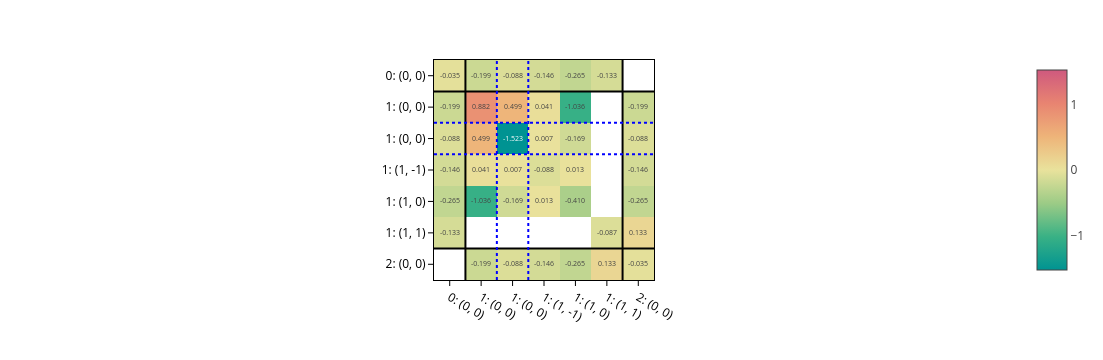

In [21]:
from graph2mat.tools.viz import plot_basis_matrix

plot_basis_matrix(
    matrix,
    config,
    point_lines={"color": "black"},
    basis_lines={"color": "blue"},
    colorscale="temps",
    text=".3f",
    basis_labels=True,
)

The black lines delimit blocks of the matrix that correspond to the same point-point interaction, and the blue dashed lines delimit the blocks of interaction between sets of basis functions.

The rows and columns are labeled as $P: (l, m)$ where $P$ is the index of the point and $l$, $m$ are the indices of the spherical harmonics.

There are some important things to note:

- **There are two white squares**. These correspond to values of the matrix that were not set. Which points are interacting for those elements? Does it make sense that we have a blank space there then?
- Look at the **interactions between points 0 and 1 and compare them to those between points 1 and 2**. How similar are they? Does it make sense?
- From the previous point, you will conclude that the reason there's something special is because the structure is symmetric. Try to move then the third point (change its position) to see if something changes. You will see that nothing changes. This is because `BasisMatrixReadout` is the rawest matrix generating module. It simply **trusts that the inputs contain all the important information** and just combines the inputs to generate the matrix. More complex subclasses of `BasisMatrixReadout` might use edge distances and directions, etc...
- As a conclusion from the previous point, we can extract that **if we change the inputs, that should induce changes in the matrix**. Try to change them, keeping in mind that the first number is a scalar and the other three a vector. Maybe **try to rotate the vector** and see what happens. You will discover that **`BasisMatrixReadout` is an equivariant function**.

Summary and next steps
-----------

In this notebook we learned the whole process to go **from the coordinates** of some points in space **to a matrix of spherical harmonics**.

The **next steps** could be:

- Understanding how to compute multiple matrices with the same function call (**batching**). See [this notebook](./Batching.ipynb).
- Understanding how to **train the function** to produce the target matrix.
- Combining this function with other modules for a particular application.